# **Imports & Config**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import ast
import numpy as np
from math import pi
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH_1 = '/content/all_classifiers_metrics.csv'

In [4]:
# Load the two CSV files
df = pd.read_csv(DATA_PATH_1)

df.head()

,classifier,balanced_accuracy_cv,f1_macro_cv,jaccard_cv,roc_auc_cv,balanced_accuracy_test,f1_macro_test,jaccard_test,roc_auc_test,cross_val_report,test_report,cross_val_confusion_matrix,test_confusion_matrix
0,RandomForest,0.727595,0.804152,0.686315,0.978159,0.814675,0.862336,0.765825,0.969600,"{""0"": {""precision"": 1.0, ""recall"": 0.607792207...","{""0"": {""precision"": 1.0, ""recall"": 0.720930232...","[[234, 147, 4], [0, 2622, 13], [0, 113, 156]]","[[31, 11, 1], [0, 290, 3], [0, 8, 22]]"
1,XGBoost,0.886526,0.903051,0.827142,0.985511,0.891315,0.901617,0.825715,0.984021,"{""0"": {""precision"": 0.9700996677740864, ""recal...","{""0"": {""precision"": 1.0, ""recall"": 0.720930232...","[[292, 88, 5], [9, 2590, 36], [0, 22, 247]]","[[31, 10, 2], [0, 289, 4], [0, 1, 29]]"
2,CatBoost,0.883669,0.788804,0.661672,0.958348,0.814959,0.731491,0.593630,0.945394,"{""0"": {""precision"": 0.696969696969697, ""recall...","{""0"": {""precision"": 0.5952380952380952, ""recal...","[[299, 69, 17], [130, 2304, 201], [0, 0, 269]]","[[25, 16, 2], [17, 253, 23], [0, 0, 30]]"
3,SVM,0.892316,0.840259,0.733268,NaN,0.851816,0.797185,0.674934,NaN,"{""0"": {""precision"": 0.8222811671087533, ""recal...","{""0"": {""precision"": 0.7441860465116279, ""recal...","[[310, 56, 19], [62, 2444, 129], [5, 10, 254]]","[[32, 9, 2], [9, 267, 17], [2, 1, 27]]"
4,CART,0.847827,0.837571,0.728734,0.882314,0.845310,0.822341,0.709392,0.885832,"{""0"": {""precision"": 0.7609254498714653, ""recal...","{""0"": {""precision"": 0.6875, ""recall"": 0.767441...","[[296, 85, 4], [91, 2482, 62], [2, 43, 224]]","[[33, 8, 2], [13, 274, 6], [2, 3, 25]]"


# **Overall accuracy**

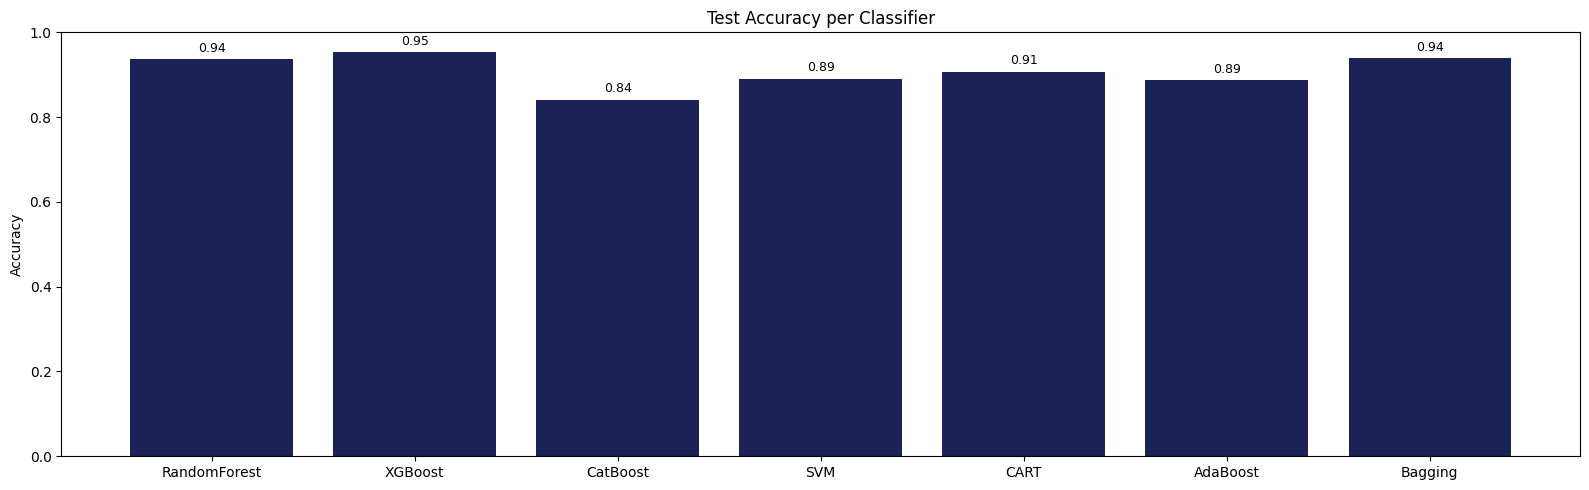

In [82]:
# Extract accuracy from test_report
accuracies = []

for idx, row in df.iterrows():
    try:
        report = json.loads(row['test_report'])
        acc = report.get("accuracy", None)
        if acc is not None:
            accuracies.append({'Classifier': row['classifier'], 'Accuracy': acc})
    except (json.JSONDecodeError, TypeError):
        continue

# Create DataFrame from extracted accuracies
acc_df = pd.DataFrame(accuracies)

# Plot
plt.figure(figsize=(16, 5))
bars = plt.bar(acc_df['Classifier'], acc_df['Accuracy'], color='#1B2256')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Classifier')

# Annotate bars with real (full-precision) values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# **Classifier Performance Comparison**

In [83]:
# Define the radar chart metrics
categories = ["Balanced Accuracy (CV)", "F1 Macro (CV)", "Balanced Accuracy (Test)", "F1 Macro (Test)"]
classifiers = list(df["classifier"])

# Extract the performance data for each classifier
stats = df[["balanced_accuracy_cv", "f1_macro_cv", "balanced_accuracy_test", "f1_macro_test"]].values

# Initialize a list to store the traces for each classifier
traces = []

# Define a color palette (you can adjust these colors)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','yellow','blue']

# Create a trace for each classifier
for i, classifier in enumerate(classifiers):
    trace = go.Scatterpolar(
        r=stats[i].tolist() +  [stats[i][0]],  # Close the circle by repeating the first value
        theta=categories + [categories[0]],  # Close the circle by repeating the first category
        fill="none",  # No filling
        name=classifier,
        opacity=1.0,  # Full opacity for lines
        line=dict(width=3, color=colors[i])  # Use distinct colors for each classifier
    )
    traces.append(trace)

# Create the layout for the radar chart
layout = go.Layout(
    title='Classifier Performance Comparison\n(CV vs. Test - Balanced Accuracy & F1 Macro)',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0.7, 1]  # Zoomed in to focus on values between 0.7 and 1
        )
    ),
    showlegend=True,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Legend below the chart
        y=-0.2,  # Adjust position of the legend
        xanchor="center",  # Center the legend horizontally
        x=0.5  # Position the legend in the middle
    )
)

# Create the figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.update_layout(
    height=500,  # Reduce the height to make the chart more compact
    width=900,   # Adjust the width of the plot
)

fig.show()

# **Balanced Accuracy CV vs Test**

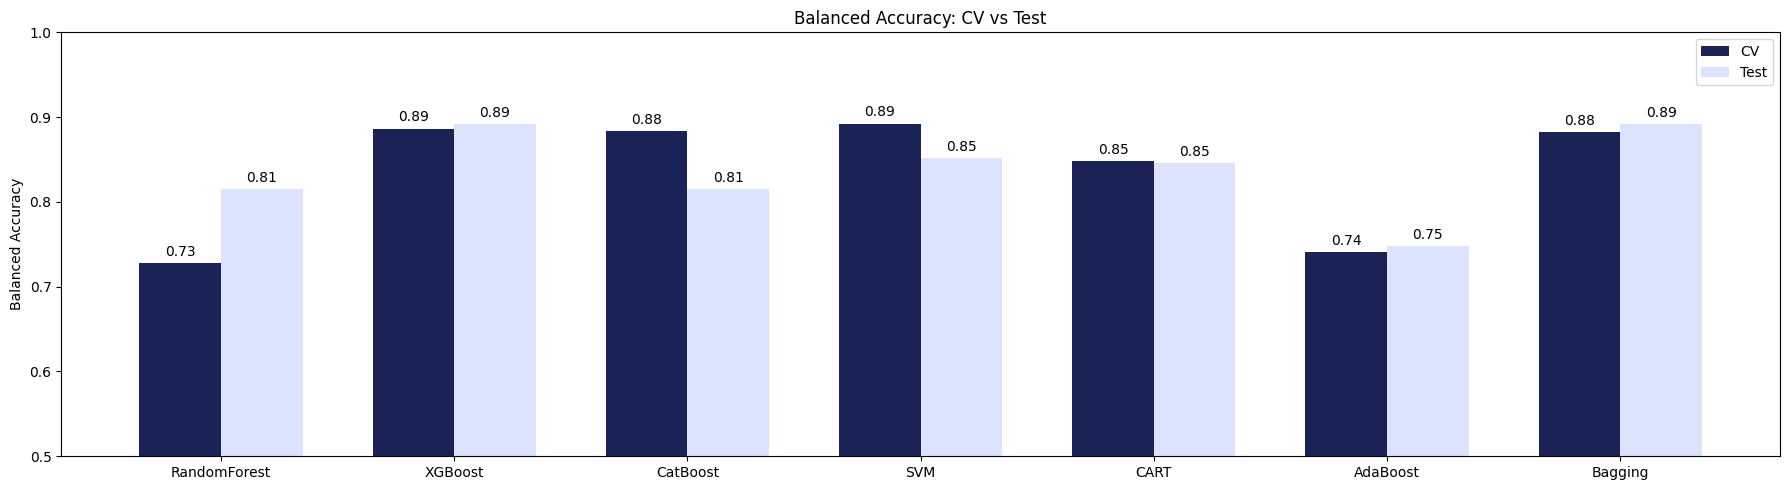

In [71]:
x = range(len(df))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 5))

bars_cv = ax.bar(x, df['balanced_accuracy_cv'], width, label='CV', color='#1B2256')
bars_test = ax.bar([i + width for i in x], df['balanced_accuracy_test'], width, label='Test', color='#DBE3FF')

# Annotate above each bar
for bar in bars_cv:
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars_test:
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(df['classifier'])
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Balanced Accuracy: CV vs Test')
ax.legend()

ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

# **F1 Macro CV vs Test**

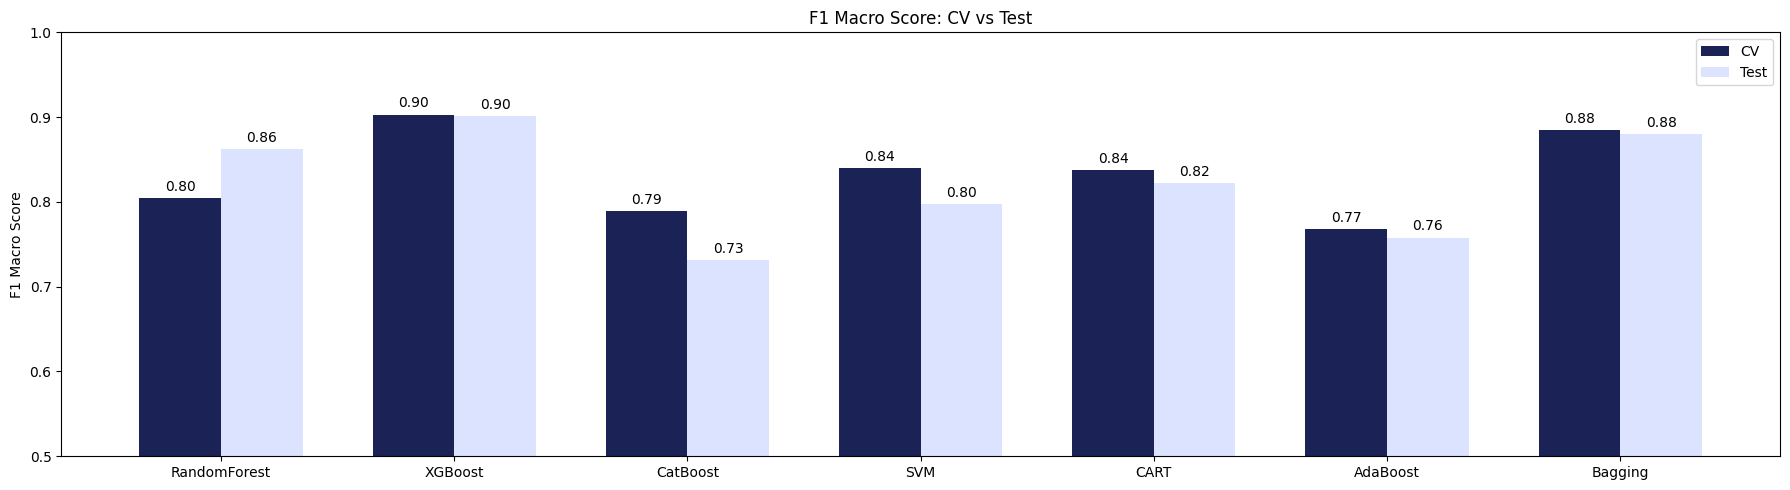

In [72]:
x = range(len(df))
width = 0.35

# Plot 2: F1 Macro CV vs Test
fig, ax = plt.subplots(figsize=(18, 5))
bars_cv = ax.bar(x, df['f1_macro_cv'], width, label='CV',color='#1B2256')
bars_test = ax.bar([i + width for i in x], df['f1_macro_test'], width, label='Test', color='#DBE3FF')

# Annotate above each bar
for i, bar in enumerate(bars_cv):
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for i, bar in enumerate(bars_test):
    ax.annotate(f'{bar.get_height():.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(df['classifier'])
ax.set_ylabel('F1 Macro Score')
ax.set_title('F1 Macro Score: CV vs Test')
ax.legend()

ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

# **Jaccard Index Comparison**

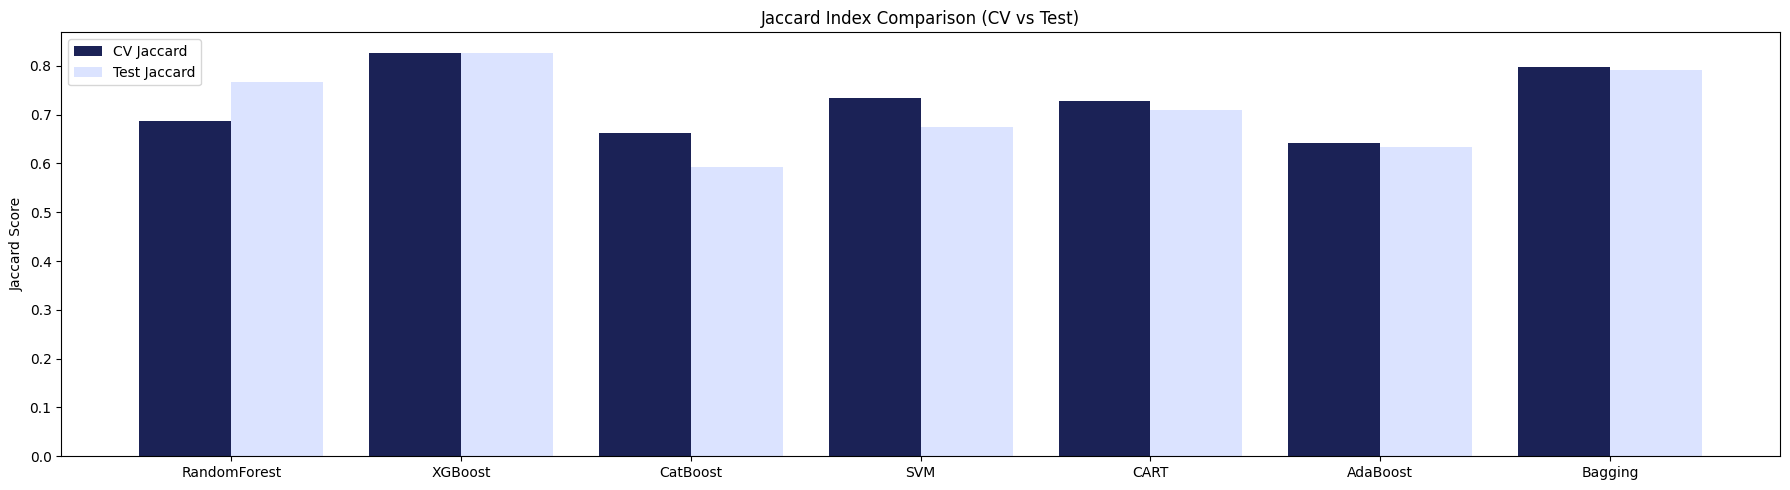

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))
x = range(len(df))
plt.bar(x, df['jaccard_cv'], width=0.4, label='CV Jaccard', align='center',color='#1B2256')
plt.bar([i + 0.4 for i in x], df['jaccard_test'], width=0.4, label='Test Jaccard', align='center', color='#DBE3FF')
plt.xticks([i + 0.2 for i in x], df['classifier'])
plt.ylabel('Jaccard Score')
plt.title('Jaccard Index Comparison (CV vs Test)')
plt.legend()
plt.tight_layout()
plt.show()

# **ROC-AUC Comparison**

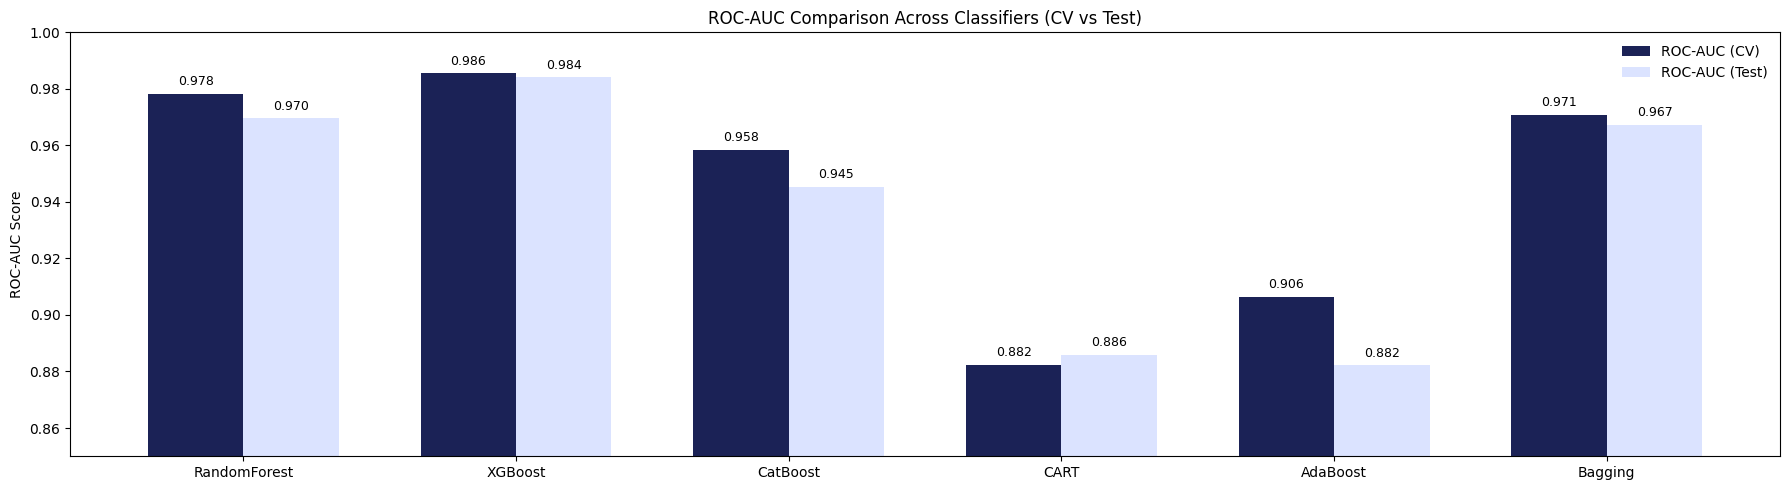

In [18]:
# Clean NaN values (SVM has NaN ROC-AUC in your data)
df_plot = df.dropna(subset=['roc_auc_cv', 'roc_auc_test']).reset_index(drop=True)

x = np.arange(len(df_plot))
width = 0.35

plt.figure(figsize=(18, 5))
plt.bar(x - width/2, df_plot['roc_auc_cv'], width, label='ROC-AUC (CV)', color='#1B2256')
plt.bar(x + width/2, df_plot['roc_auc_test'], width, label='ROC-AUC (Test)', color='#DBE3FF')

# Labels & formatting
plt.xticks(x, df_plot['classifier'])
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Comparison Across Classifiers (CV vs Test)')
plt.ylim(0.85, 1.00)
plt.legend(frameon=False)

# Annotate values on bars
for i in range(len(df_plot)):
    plt.text(x[i] - width/2, df_plot['roc_auc_cv'][i] + 0.002, f"{df_plot['roc_auc_cv'][i]:.3f}",
             ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, df_plot['roc_auc_test'][i] + 0.002, f"{df_plot['roc_auc_test'][i]:.3f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# **Confusion Matrix**

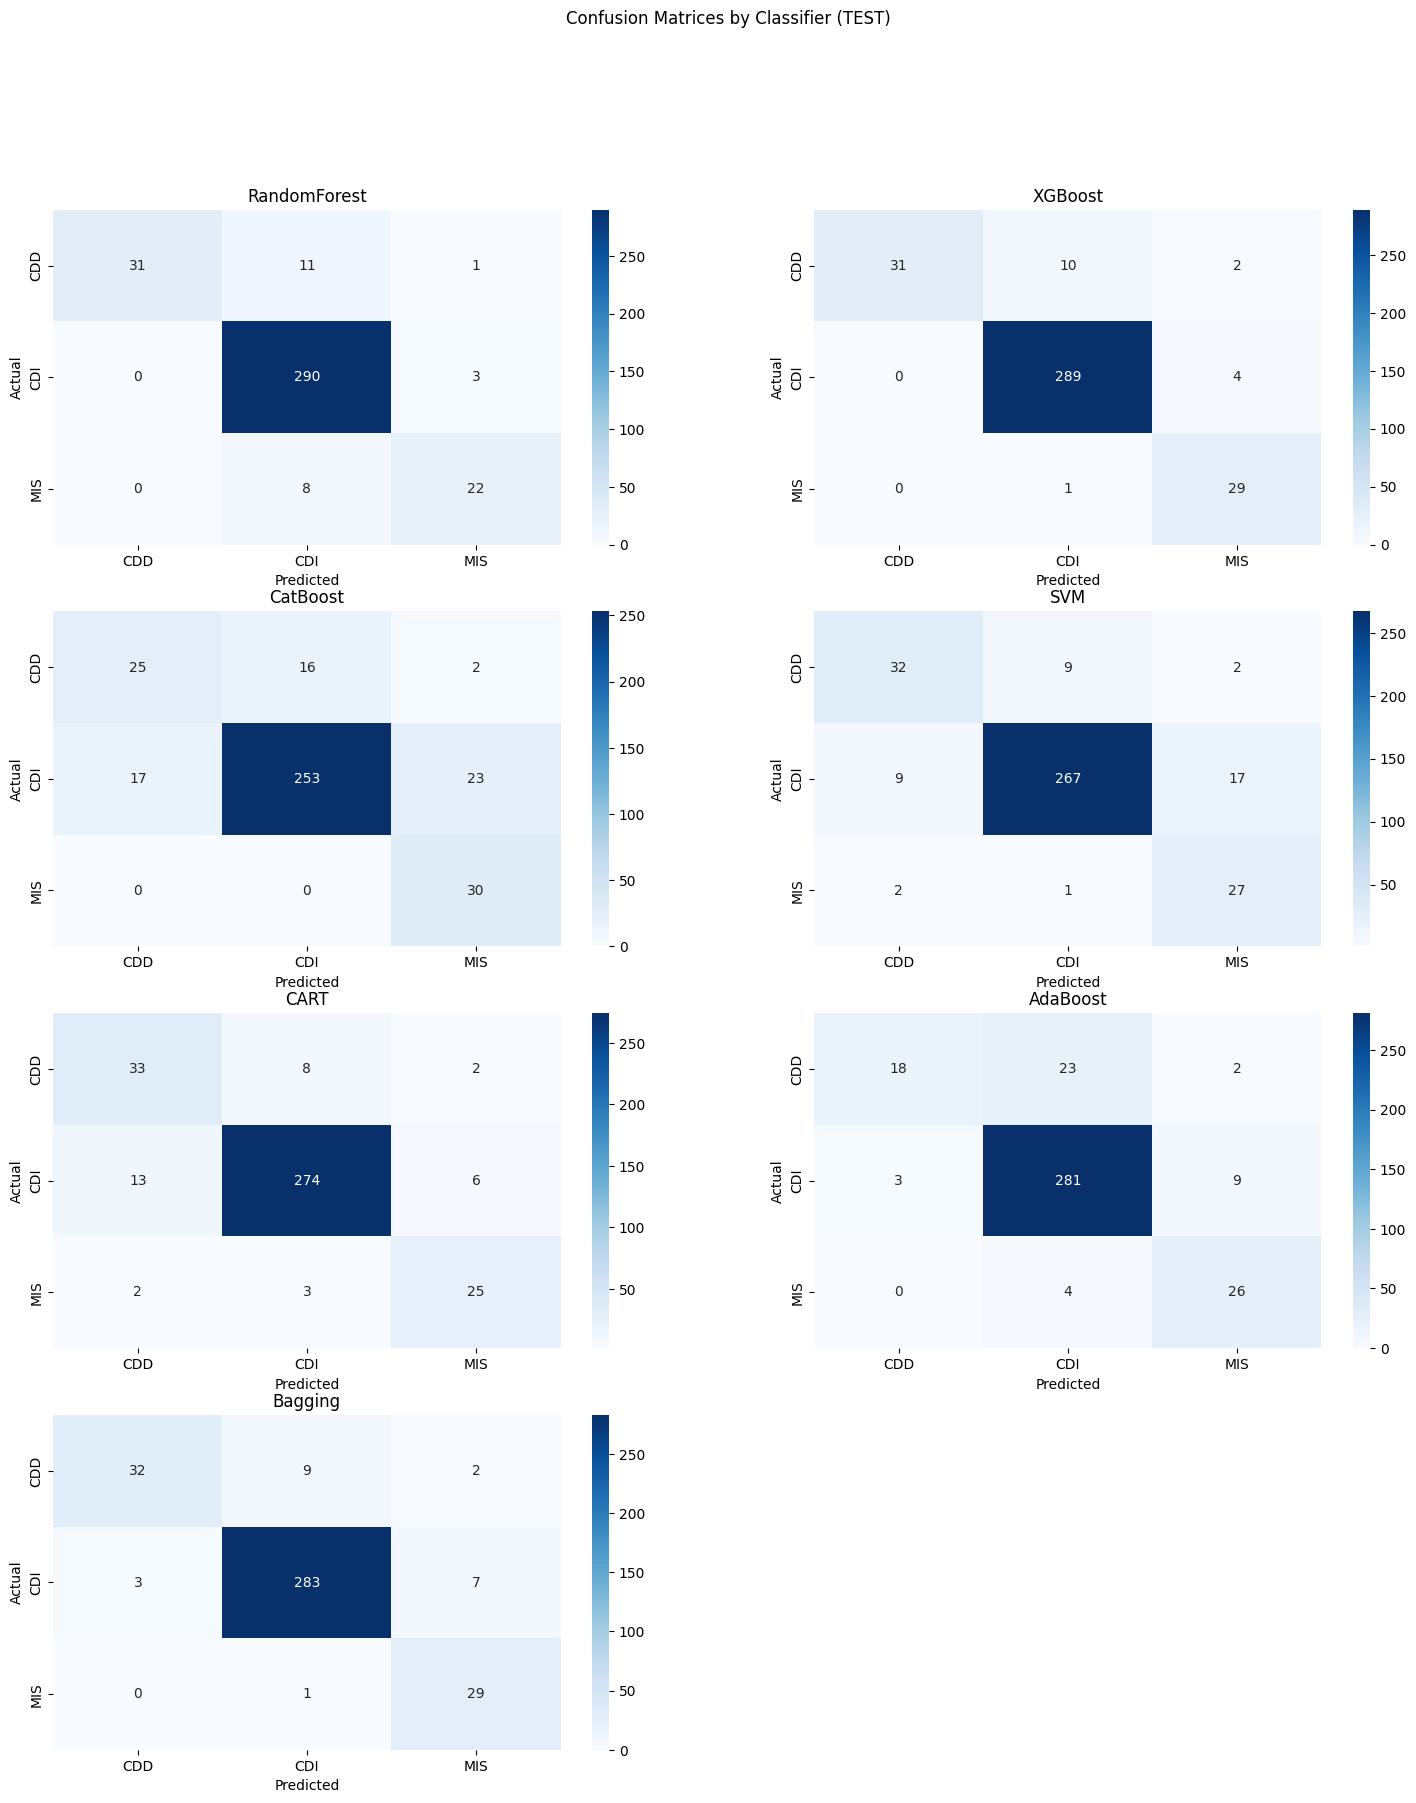

In [76]:
# Number of classifiers
num_classifiers = len(df)
cols = 2
rows = math.ceil(num_classifiers / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for idx, (i, row) in enumerate(df.iterrows()):
    model_name = row["classifier"]
    cm_data = json.loads(row["test_confusion_matrix"])  # Assuming it's a stringified list

    cm = pd.DataFrame(cm_data)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=['CDD','CDI','MIS'],
        yticklabels=['CDD','CDI','MIS'],
        ax=axes[idx]
    )
    axes[idx].set_title(f"{model_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices by Classifier (TEST)", fontsize=12)

plt.show()

# **Classifiers Report**

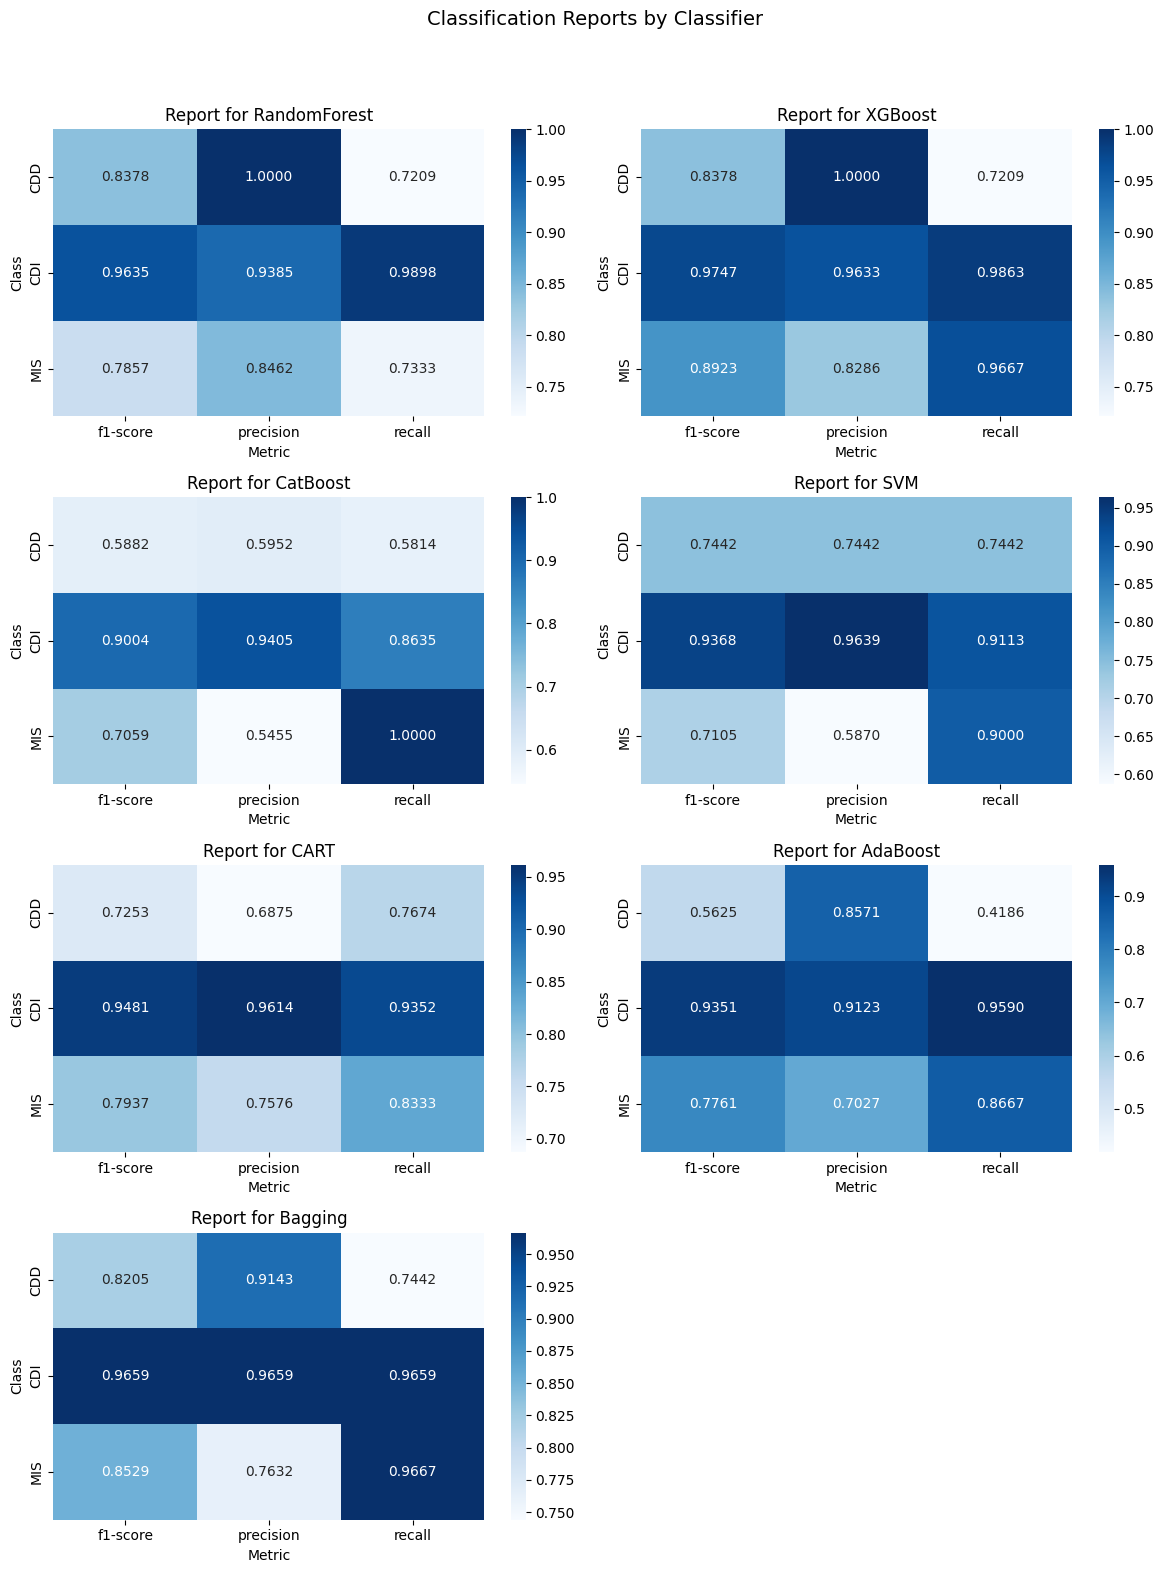

In [77]:
# Convert test_report string to dict safely
def safe_json_load(x):
    try:
        return json.loads(x) if isinstance(x, str) else None
    except:
        return None

df['report_dict'] = df['test_report'].apply(safe_json_load)

# Extract metrics
records = []
for idx, row in df.iterrows():
    classifier = row['classifier']
    report = row['report_dict']
    if isinstance(report, dict):
        for cls, metrics in report.items():
            if cls in ['0', '1', '2'] and isinstance(metrics, dict):
                for metric in ['precision', 'recall', 'f1-score']:
                    if metric in metrics:
                        records.append({
                            'Classifier': classifier,
                            'Class': cls,
                            'Metric': metric,
                            'Value': metrics[metric]
                        })

# Create a clean DataFrame
report_df = pd.DataFrame(records)

# Map class numbers to names
class_mapping = {'0': 'CDD', '1': 'CDI', '2': 'MIS'}
report_df['Class'] = report_df['Class'].map(class_mapping)

# List of classifiers
classifiers = df['classifier'].tolist()

# Grid layout
cols = 2
rows = math.ceil(len(classifiers) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

# Plot heatmaps for each classifier
for idx, cl in enumerate(classifiers):
    filtered_df = report_df[report_df['Classifier'] == cl]
    pivot_df = filtered_df.pivot(index='Class', columns='Metric', values='Value')

    sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"Report for {cl}")
    axes[idx].set_xlabel("Metric")
    axes[idx].set_ylabel("Class")

# Remove unused axes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Classification Reports by Classifier", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()